# **2.4 Evaluating Hyperparameters**

## **Optimising Weather Prediction Models for Air Ambulance Operations**
This project explores how optimised machine learning models can improve aviation safety forecasting. An air ambulance provider has approached ClimateWins to identify days when flying conditions are safest with the highest possible precision. To support this, I apply hyperparameter searches on Deep Learning models, iteratively refining them to achieve peak performance

## Table of Contents  
- [1. Import Libraries](#1-import-libraries)  
- [2. Load Data](#2-load-data)
- [3. Clean Data](#3-clean-data)  
- [4. Reshape Data](#4-reshape-data)
- [5. Train/Test Split](#5-train/test-split)  
- [6. Bayesian Optimization](#6-bayesian-optimization)  
- [7. Confusion Matrix](#7-confusion-matrix)  

---

## 1. Import Libraries

Here’s where I load the Python packages I’ll need:

- Core tools: `pandas`, `numpy`, and `math` for data handling and calculations
- Visualisation: `matplotlib` and `seaborn` for exploratory data analysis and charts
- Machine learning (scikit-learn): `GridSearchCV`, `RandomizedSearchCV`, `StratifiedKFold`, and model evaluation metrics like `accuracy_score`
- Deep learning (Keras): a range of layers (`Dense`, `Dropout`, `Conv1D`, `Conv2D`, `BatchNormalization`, `Flatten`, `MaxPooling1D`), optimisers (`Adam`, `SGD`, `RMSprop`, etc.), callbacks (`EarlyStopping`, `ModelCheckpoint`), and wrappers like `KerasClassifier`
- Advanced optimisation: `BayesianOptimization` for searching hyperparameter spaces more efficiently
- Utilities: `time` for runtime tracking and warnings for cleaner outputs

These libraries provide the full toolkit for experimenting with both deep learning and random forest models, and for running extensive hyperparameter searches to optimise performance.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils.multiclass import type_of_target

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LeakyReLU
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping

from bayes_opt import BayesianOptimization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, Conv2D, Dense, Dropout, BatchNormalization,
    Flatten, MaxPooling1D, LeakyReLU
)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # Only for debugging

from scikeras.wrappers import KerasClassifier

from math import floor
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

---

## 2. Load Data

I’m loading in the cleaned weather observations (`X`) and the target column for whether the day was considered “pleasant” or not (`y`).  
Just checking the shapes and and the first few rows to make sure everything came in clean and looks right.

In [19]:
# Create a path to where my data is stored
path = r'/Users/yaseminmustafa/Desktop/CareerFoundry/Specialisation'

In [20]:
# Load the data
X = pd.read_csv(os.path.join(path, 'Achievement 2', '2.2', 'weather_cleaned.csv'))
y = pd.read_csv(os.path.join(path, 'Achievement 1', '1.4', 'pleasant_weather_answers.csv'))

In [21]:
# Check shape and preview data
print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (22950, 135)
y shape: (22950, 16)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,BELGRADE_humidity,BELGRADE_pressure,BELGRADE_global_radiation,BELGRADE_precipitation,BELGRADE_sunshine,BELGRADE_temp_mean,BELGRADE_temp_min,BELGRADE_temp_max,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_sunshine,BUDAPEST_temp_mean,BUDAPEST_temp_min,BUDAPEST_temp_max,DEBILT_cloud_cover,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_sunshine,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DUSSELDORF_cloud_cover,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_sunshine,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_sunshine,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,LJUBLJANA_cloud_cover,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_sunshine,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,MAASTRICHT_cloud_cover,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_sunshine,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MADRID_cloud_cover,MADRID_humidity,MADRID_pressure,MADRID_global_radiation,MADRID_precipitation,MADRID_sunshine,MADRID_temp_mean,MADRID_temp_min,MADRID_temp_max,MUNCHENB_cloud_cover,MUNCHENB_humidity,MUNCHENB_global_radiation,MUNCHENB_precipitation,MUNCHENB_sunshine,MUNCHENB_temp_mean,MUNCHENB_temp_min,MUNCHENB_temp_max,OSLO_cloud_cover,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_pressure,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_sunshine,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,0.81,1.0195,0.88,0.00,7.0,3.7,-0.9,7.9,4,0.67,1.017,0.44,0.01,2.3,2.4,-0.4,5.1,7,0.85,1.0032,0.07,0.25,0.0,9.3,7.4,11.0,8,0.83,1.0161,0.12,0.08,0.0,10.0,7.0,11.5,7,0.91,1.0010,0.13,0.22,0.0,10.6,9.4,8.3,0.82,1.0094,0.28,0.48,1.6,7.9,3.9,9.4,8,1.00,1.0173,0.20,0.00,0.0,-0.6,-1.9,0.5,7,0.83,1.0063,0.22,0.32,1.0,9.5,8.5,11.1,6,0.92,1.0260,0.53,0.0,1.4,7.6,4.4,10.8,5,0.67,0.20,0.10,0.0,6.9,1.1,10.4,8,0.98,0.9978,0.04,1.14,0.0,4.9,3.8,5.9,4,0.73,1.0304,0.48,0.01,2.3,-5.9,-8.5,-3.2,5,1.0114,0.05,0.32,0.0,4.2,2.2,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9,8,1.0304,0.98
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,0.84,1.0172,0.25,0.00,0.0,2.9,2.2,4.4,4,0.67,1.017,0.18,0.31,0.0,2.3,1.4,3.1,8,0.90,1.0056,0.14,0.06,0.1,7.7,6.4,8.3,8,0.89,1.0161,0.18,0.66,0.5,8.2,7.4,11.0,7,0.98,1.0051,0.13,0.23,0.0,6.1,3.9,10.6,0.86,1.0086,0.12,0.27,0.0,7.7,6.8,9.1,6,0.94,1.0173,0.56,0.13,3.2,2.1,-1.3,5.5,8,0.92,1.0062,0.17,1.34,0.4,8.6,7.5,9.9,7,0.86,1.0254,0.46,0.0,0.9,9.8,7.4,12.2,6,0.72,0.61,0.30,5.1,6.2,4.2,10.2,8,0.62,1.0139,0.04,0.00,0.0,3.4,2.8,4.9,6,0.97,1.0292,0.21,0.61,0.0,-9.5,-10.5,-8.5,5,1.0114,0.05,0.06,0.0,4.0,3.0,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1,6,1.0292,0.62
2,8,0.90,1.018,0.18,0.30,0.0,8.5,5.1,9.9,6,0.77,1.0179,0.67,0.00,3.5,3.1,-0.5,6.4,4,0.67,1.017,0.30,0.00,0.6,2.7,1.7,5.3,6,0.92,1.0165,0.28,0.0

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19600102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19600103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,19600104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19600105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## 3. Data Cleaning

The dataset had already undergone initial cleaning; however, I will perform a quick check for any missing values or duplicate rows to ensure data integrity. I will also review the column names to confirm there are no unusual characters or extra spaces that might cause issues during processing. Additionally, since the date column is present in the y DataFrame and is not required for modelling, I will remove it.

In [22]:
# Data Cleaning

# Check for missing values
print("Missing values in X:")
print(X.isnull().sum().sum())

print("\nMissing values in y:")
print(y.isnull().sum().sum())

# Check for duplicates
print("\nDuplicate rows in X:", X.duplicated().sum())
print("Duplicate rows in y:", y.duplicated().sum())

# Check column names
print("\nFirst 5 column names in X:")
print(X.columns[:5])

Missing values in X:
0

Missing values in y:
0

Duplicate rows in X: 0
Duplicate rows in y: 0

First 5 column names in X:
Index(['BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure',
       'BASEL_global_radiation', 'BASEL_precipitation'],
      dtype='object')


In [23]:
# Drop the 'date' column
y = y.drop(columns=['DATE'])

In [24]:
# Check shape and preview data
print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (22950, 135)
y shape: (22950, 15)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,BELGRADE_humidity,BELGRADE_pressure,BELGRADE_global_radiation,BELGRADE_precipitation,BELGRADE_sunshine,BELGRADE_temp_mean,BELGRADE_temp_min,BELGRADE_temp_max,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_sunshine,BUDAPEST_temp_mean,BUDAPEST_temp_min,BUDAPEST_temp_max,DEBILT_cloud_cover,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_sunshine,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DUSSELDORF_cloud_cover,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_sunshine,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_sunshine,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,LJUBLJANA_cloud_cover,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_sunshine,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,MAASTRICHT_cloud_cover,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_sunshine,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MADRID_cloud_cover,MADRID_humidity,MADRID_pressure,MADRID_global_radiation,MADRID_precipitation,MADRID_sunshine,MADRID_temp_mean,MADRID_temp_min,MADRID_temp_max,MUNCHENB_cloud_cover,MUNCHENB_humidity,MUNCHENB_global_radiation,MUNCHENB_precipitation,MUNCHENB_sunshine,MUNCHENB_temp_mean,MUNCHENB_temp_min,MUNCHENB_temp_max,OSLO_cloud_cover,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_pressure,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_sunshine,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,0.81,1.0195,0.88,0.00,7.0,3.7,-0.9,7.9,4,0.67,1.017,0.44,0.01,2.3,2.4,-0.4,5.1,7,0.85,1.0032,0.07,0.25,0.0,9.3,7.4,11.0,8,0.83,1.0161,0.12,0.08,0.0,10.0,7.0,11.5,7,0.91,1.0010,0.13,0.22,0.0,10.6,9.4,8.3,0.82,1.0094,0.28,0.48,1.6,7.9,3.9,9.4,8,1.00,1.0173,0.20,0.00,0.0,-0.6,-1.9,0.5,7,0.83,1.0063,0.22,0.32,1.0,9.5,8.5,11.1,6,0.92,1.0260,0.53,0.0,1.4,7.6,4.4,10.8,5,0.67,0.20,0.10,0.0,6.9,1.1,10.4,8,0.98,0.9978,0.04,1.14,0.0,4.9,3.8,5.9,4,0.73,1.0304,0.48,0.01,2.3,-5.9,-8.5,-3.2,5,1.0114,0.05,0.32,0.0,4.2,2.2,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9,8,1.0304,0.98
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,0.84,1.0172,0.25,0.00,0.0,2.9,2.2,4.4,4,0.67,1.017,0.18,0.31,0.0,2.3,1.4,3.1,8,0.90,1.0056,0.14,0.06,0.1,7.7,6.4,8.3,8,0.89,1.0161,0.18,0.66,0.5,8.2,7.4,11.0,7,0.98,1.0051,0.13,0.23,0.0,6.1,3.9,10.6,0.86,1.0086,0.12,0.27,0.0,7.7,6.8,9.1,6,0.94,1.0173,0.56,0.13,3.2,2.1,-1.3,5.5,8,0.92,1.0062,0.17,1.34,0.4,8.6,7.5,9.9,7,0.86,1.0254,0.46,0.0,0.9,9.8,7.4,12.2,6,0.72,0.61,0.30,5.1,6.2,4.2,10.2,8,0.62,1.0139,0.04,0.00,0.0,3.4,2.8,4.9,6,0.97,1.0292,0.21,0.61,0.0,-9.5,-10.5,-8.5,5,1.0114,0.05,0.06,0.0,4.0,3.0,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1,6,1.0292,0.62
2,8,0.90,1.018,0.18,0.30,0.0,8.5,5.1,9.9,6,0.77,1.0179,0.67,0.00,3.5,3.1,-0.5,6.4,4,0.67,1.017,0.30,0.00,0.6,2.7,1.7,5.3,6,0.92,1.0165,0.28,0.0

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## 4. Reshape Data
The feature matrix X and target vector y are initially in tabular form. For compatibility with our CNN model, X must be reshaped into a 3D array with dimensions (samples, timesteps, features) — in this case (22950, 15, 9). This preserves the temporal order of the sequences for convolutional processing. The target vector y is converted from one-hot or categorical format into a 1D array of class indices using argmax, ensuring it matches the expected input for multiclass classification. Finally, we confirm the shapes and verify that y is recognized as a multiclass target.

In [25]:
# Confirm the current shapes
print("X shape (before reshaping):", X.shape)
print("y shape:", y.shape)

X shape (before reshaping): (22950, 135)
y shape: (22950, 15)


In [26]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)
X

array([[7.    , 0.85  , 1.018 , ..., 8.    , 1.0304, 0.98  ],
       [6.    , 0.84  , 1.018 , ..., 6.    , 1.0292, 0.62  ],
       [8.    , 0.9   , 1.018 , ..., 8.    , 1.032 , 0.69  ],
       ...,
       [4.    , 0.76  , 1.0227, ..., 3.    , 1.0263, 0.85  ],
       [5.    , 0.8   , 1.0212, ..., 3.    , 1.0263, 0.94  ],
       [5.    , 0.84  , 1.0193, ..., 3.    , 1.0263, 0.97  ]])

In [27]:
# Reshape X to 3D
X = X.reshape(-1, 15, 9)  # -1 tells NumPy to figure out the number of smaples automatically based on the other dimensions

In [28]:
# Confirm the final shape 
print("Final X shape:", X.shape)  # should be (22950, 15, 9)
print("Final y shape:", y.shape)  # should be (22950,)

Final X shape: (22950, 15, 9)
Final y shape: (22950, 15)


In [29]:
# Use argmax to convert to 1D 
y = np.argmax(y, axis=1)

In [30]:
# Confirm the final shape
print("Final X shape:", X.shape)  # should be (22950, 15, 9)
print("Final y shape:", y.shape)  # should be (22950,)

Final X shape: (22950, 15, 9)
Final y shape: (22950,)


In [31]:
# Check type
print("y type:", type_of_target(y))

y type: multiclass


---

## 5. Train/Test Split
Before training, the target labels y are encoded as integer class indices using LabelEncoder to ensure consistency with model expectations. The dataset is then split into training and testing subsets, using an 80/20 ratio while preserving class distribution via stratification. After the split, the number of unique classes is calculated (num_classes) to properly configure the output layer of the model. Finally, the integer labels are one-hot encoded with to_categorical to create Y_train and Y_test, which are suitable for multiclass classification in Keras.

In [32]:
# Encode labels to integers 0..num_classes-1
le = LabelEncoder()
y = le.fit_transform(y)

In [33]:
# Split the data set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_classes = len(np.unique(y_train))

In [34]:
Y_train = to_categorical(y_train, num_classes=num_classes)
Y_test = to_categorical(y_test, num_classes=num_classes)

print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

Y_train shape: (18360, 14)
Y_test shape: (4590, 14)


---

## 6. Bayesian Optimization
To systematically tune the CNN hyperparameters, I implement Bayesian Optimization, which efficiently searches the parameter space by balancing exploration and exploitation. The bay_area function defines the model structure and maps continuous or categorical hyperparameters (e.g. neurons, kernel size etc.) to a Keras Sequential model. Continuous values are rounded to integers where appropriate, and categorical choices are mapped to valid options. The model is evaluated using 5-fold cross-validation with accuracy as the scoring metric, ensuring robust performance estimates.
The optimisation process identifies the best hyperparameters, which are then extracted and used to build the final CNN model. A new optimiser instance is created to avoid Keras variable conflicts, and the model is compiled with categorical_crossentropy loss and the selected optimiser. Training is performed on the training set with a validation split, and the final training, validation, and test accuracies are recorded. This approach stabilises learning, improves generalisation, and mitigates overfitting compared to arbitrary hyperparameter selections.

In [35]:
# Bayesian Optimization function
timesteps = X_train.shape[1]
input_dim = X_train.shape[2]

# Create function
def bay_area(neurons, activation, kernel, optimizer, learning_rate, batch_size,
             epochs, layers1, layers2, normalization, dropout, dropout_rate):

    # Convert continuous floats to integers
    neurons = int(round(neurons))
    kernel = int(round(kernel))
    batch_size = int(round(batch_size))
    epochs = int(round(epochs))
    layers1 = int(round(layers1))
    layers2 = int(round(layers2))

    # Categorical choices
    optimizer_list = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    activation_list = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', LeakyReLU]

    chosen_optimizer = optimizer_list[int(np.clip(round(optimizer), 0, len(optimizer_list)-1))]
    chosen_activation = activation_list[int(np.clip(round(activation), 0, len(activation_list)-1))]

    learning_rate = max(learning_rate, 0.0001)
    dropout_rate = np.clip(dropout_rate, 0, 0.5)
    normalization = bool(round(normalization))
    dropout = bool(round(dropout))

    def cnn_model():
        model = Sequential()
        model.add(Conv1D(filters=neurons, kernel_size=kernel, activation=chosen_activation, input_shape=(timesteps, input_dim)))
        if normalization:
            model.add(BatchNormalization())

        for _ in range(layers1-1):
            model.add(Conv1D(filters=neurons, kernel_size=kernel, activation=chosen_activation))
            if dropout:
                model.add(Dropout(dropout_rate))
            model.add(MaxPooling1D())

        for _ in range(layers2):
            model.add(Dense(neurons, activation=chosen_activation))
            if dropout:
                model.add(Dropout(dropout_rate))

        model.add(Flatten())
        model.add(Dense(num_classes, activation='softmax'))

        optim_dict = {
            'Adam': Adam(learning_rate=learning_rate),
            'SGD': SGD(learning_rate=learning_rate),
            'RMSprop': RMSprop(learning_rate=learning_rate),
            'Adadelta': Adadelta(learning_rate=learning_rate),
            'Adagrad': Adagrad(learning_rate=learning_rate),
            'Adamax': Adamax(learning_rate=learning_rate),
            'Nadam': Nadam(learning_rate=learning_rate),
            'Ftrl': Ftrl(learning_rate=learning_rate)
        }

        model.compile(loss='sparse_categorical_crossentropy', optimizer=optim_dict[chosen_optimizer], metrics=['accuracy'])
        return model

    nn = KerasClassifier(build_fn=cnn_model, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score_acc = make_scorer(accuracy_score)
    try:
        score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold).mean()
    except:
        score = 0
    return score

In [36]:
# Bayesian Optimization
params = {
    'neurons': (10, 100),
    'kernel': (1, 3),
    'activation': (0, 9),
    'optimizer': (0, 7),
    'learning_rate': (0.01, 1),
    'batch_size': (200, 1000),
    'epochs': (20, 100),
    'layers1': (1, 3),
    'layers2': (1, 3),
    'normalization': (0, 1),
    'dropout': (0, 1),
    'dropout_rate': (0, 0.3)
}

start = time.time()
nn_opt = BayesianOptimization(bay_area, params, random_state=42)
nn_opt.maximize(init_points=5, n_iter=2)  # small numbers for testing
print('Search took %s minutes' % ((time.time() - start)/60))

optimum = nn_opt.max['params']

|   iter    |  target   |  neurons  |  kernel   | activa... | optimizer | learni... | batch_... |  epochs   |  layers1  |  layers2  | normal... |  dropout  | dropou... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6434095 | 43.708610 | 2.9014286 | 6.5879454 | 4.1906093 | 0.1644584 | 324.79561 | 24.646688 | 2.7323522 | 2.2022300 | 0.7080725 | 0.0205844 | 0.2909729 |
| 2         | 0.6433551 | 84.919837 | 1.4246782 | 1.6364247 | 1.2838315 | 0.3111998 | 619.80514 | 54.555601 | 1.5824582 | 2.2237057 | 0.1394938 | 0.2921446 | 0.1099085 |
| 3         | 0.8053921 | 51.046298 | 2.5703519 | 1.7970640 | 3.5996410 | 0.5964904 | 237.16033 | 68.603588 | 1.3410482 | 1.1301031 | 0.9488855 | 0.9656320 | 0.2425192 |
| 4         | 0.7421568 | 37.415239 | 1.1953442 | 6.1580972 | 3.0810674 | 0.1308178 | 596.14152 | 22.751081 | 2.8186408 | 1.5175599 | 0.6625222 | 0.31

In [53]:
# Check what optimum contains
print(optimum)

{'neurons': 51, 'kernel': 2.570351922786027, 'activation': 'softplus', 'optimizer': <keras.src.optimizers.adagrad.Adagrad object at 0x152635f10>, 'learning_rate': 0.596490423173422, 'batch_size': 237, 'epochs': 69, 'layers1': 1, 'layers2': 1, 'normalization': 0.9488855372533332, 'dropout': 0.9656320330745594, 'dropout_rate': 0.24251920443493832}


In [58]:
# Extract optimized hyperparameters
neurons          = int(round(optimum['neurons']))
kernel           = int(round(optimum['kernel']))
chosen_activation= optimum['activation']      # already a string
optimizer_name   = type(optimum['optimizer']).__name__  # get class name
learning_rate    = optimum['learning_rate']
batch_size       = int(round(optimum['batch_size']))
epochs           = int(round(optimum['epochs']))
layers1          = int(round(optimum['layers1']))
layers2          = int(round(optimum['layers2']))
dropout_rate     = float(optimum['dropout_rate'])
normalization    = optimum['normalization'] > 0.5
dropout_flag     = optimum['dropout'] > 0.5

timesteps = X_train.shape[1]
input_dim  = X_train.shape[2]

In [59]:
# Create new optimizer instance
optim_dict = {
    'Adam': Adam(learning_rate=learning_rate),
    'SGD': SGD(learning_rate=learning_rate),
    'RMSprop': RMSprop(learning_rate=learning_rate),
    'Adadelta': Adadelta(learning_rate=learning_rate),
    'Adagrad': Adagrad(learning_rate=learning_rate),
    'Adamax': Adamax(learning_rate=learning_rate),
    'Nadam': Nadam(learning_rate=learning_rate),
    'Ftrl': Ftrl(learning_rate=learning_rate)
}

chosen_optimizer = optim_dict[optimizer_name]

In [60]:
# Build final model
model = Sequential()
model.add(Conv1D(filters=neurons,
                 kernel_size=kernel,
                 activation=chosen_activation,
                 input_shape=(timesteps, input_dim)))

if normalization:
    model.add(BatchNormalization())
if dropout_flag:
    model.add(Dropout(dropout_rate))

# Add hidden Dense layers
for _ in range(layers1 - 1):
    model.add(Dense(neurons, activation=chosen_activation))
    if dropout_flag:
        model.add(Dropout(dropout_rate))

for _ in range(layers2):
    model.add(Dense(neurons, activation=chosen_activation))
    if dropout_flag:
        model.add(Dropout(dropout_rate))

model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


In [61]:
# Compile with new optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=chosen_optimizer,
              metrics=['accuracy'])

In [62]:
# Train the model
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/69
62/62 - 5s - 73ms/step - accuracy: 0.6286 - loss: 3.4448 - val_accuracy: 0.6130 - val_loss: 1.1006
Epoch 2/69
62/62 - 4s - 68ms/step - accuracy: 0.6449 - loss: 1.0240 - val_accuracy: 0.5379 - val_loss: 1.2124
Epoch 3/69
62/62 - 4s - 69ms/step - accuracy: 0.6483 - loss: 1.0003 - val_accuracy: 0.6631 - val_loss: 0.9820
Epoch 4/69
62/62 - 4s - 64ms/step - accuracy: 0.6526 - loss: 0.9678 - val_accuracy: 0.6683 - val_loss: 1.0726
Epoch 5/69
62/62 - 4s - 64ms/step - accuracy: 0.6623 - loss: 0.9398 - val_accuracy: 0.6691 - val_loss: 0.9262
Epoch 6/69
62/62 - 4s - 65ms/step - accuracy: 0.6660 - loss: 0.9319 - val_accuracy: 0.6748 - val_loss: 0.9050
Epoch 7/69
62/62 - 4s - 65ms/step - accuracy: 0.6735 - loss: 0.9055 - val_accuracy: 0.6718 - val_loss: 0.9013
Epoch 8/69
62/62 - 4s - 63ms/step - accuracy: 0.6753 - loss: 0.8954 - val_accuracy: 0.6732 - val_loss: 0.8994
Epoch 9/69
62/62 - 4s - 64ms/step - accuracy: 0.6746 - loss: 0.8856 - val_accuracy: 0.6748 - val_loss: 0.8659
Epoch 10/6

In [63]:
# Evaluation of accuracies
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy:", test_acc)

Training accuracy: 0.7386982440948486
Validation accuracy: 0.7426470518112183
Test accuracy: 0.7498910427093506


---

## 7. Confusion Matrix
After training the final CNN model, I evaluate its performance across all classes using a confusion matrix. The model predicts class probabilities for the test set, which are then converted to discrete class indices. These predictions are compared against the true labels to generate the confusion matrix, providing a detailed view of which stations are correctly or incorrectly classified. Station names are used as axis labels to improve interpretability. This visualisation helps assess overall model accuracy, identify misclassifications, and check whether all 15 stations are recognised.

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_probs = model.predict(X_test)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 


In [69]:
# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)   # since Y_test is one-hot

In [70]:
# Define station labels in order corresponding to your class indices
station_labels = ['BASEL', 'BELGRADE''BUDAPEST', 'DEBLIT', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 
                  'LJUBLIJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK',
                  'STOCKHOLM', 'VALENTIA'] 

In [71]:
# Compute confusion matrix with labels
cm = confusion_matrix(y_true, y_pred, labels=range(len(station_labels)))

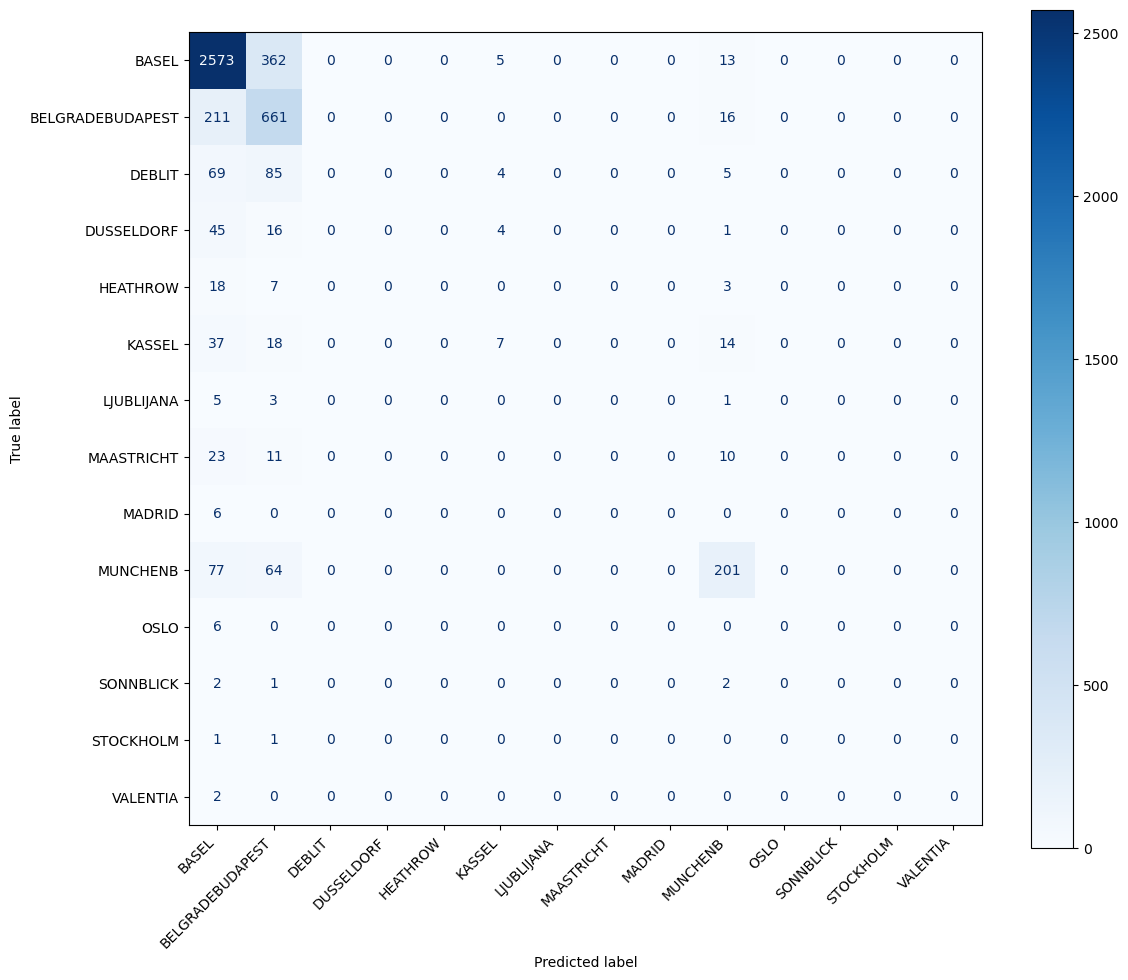

In [76]:
# Display confusion matrix with proper labels
fig, ax = plt.subplots(figsize=(12, 10))  # Increase figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=station_labels)
disp.plot(cmap="Blues", values_format="d", ax=ax)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)  # optional: keep y-axis labels horizontal

plt.tight_layout()  # Adjust layout so labels aren't cut off

# Save the figure to a file
plt.savefig("confusion_matrix.png", dpi=300)  # high-res PNG

plt.show()

In [77]:
# Check if the model recognises all 15 stations
predicted_stations = {station_labels[i] for i in np.unique(y_pred)}
all_stations = set(station_labels)

if all_stations.issubset(predicted_stations):
    print("The model recognized all 15 stations.")
else:
    missing = all_stations - predicted_stations
    print(f"The model did NOT recognize all stations. Missing: {missing}")

The model did NOT recognize all stations. Missing: {'OSLO', 'HEATHROW', 'LJUBLIJANA', 'DEBLIT', 'MADRID', 'MAASTRICHT', 'VALENTIA', 'STOCKHOLM', 'SONNBLICK', 'DUSSELDORF'}
